# 第2章 最小二乗法：機械学習理論の第一歩

## 「02-square_error.py」の解説

ITエンジニアための機械学習理論入門「第2章 最小二乗法:機械学習理論の第一歩」で使用しているサンプルコード「02-square_error.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

### データ数 N=10 の場合

はじめに必要なモジュールをインポートしておきます。

関数 normal は、正規分布に従う乱数を生成するために利用します。

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal

import matplotlib
matplotlib.rcParams['font.size'] = 12

正弦関数に正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、0≦x≦1 の区間を等分した num 個の点 x に対して、対応する y の値を生成します。

In [0]:
# データセット {x_n,y_n} (n=1...num) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x', 'y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x, y], index=['x', 'y']),
                                 ignore_index=True)
    return dataset

例として、10個のデータをトレーニングセットとして生成します。

In [3]:
N=10            # サンプルを取得する位置 x の個数
train_set = create_dataset(N)
train_set

,x,y
0,0.000000,-0.397567
1,0.111111,0.697741
2,0.222222,0.588465
3,0.333333,1.012846
4,0.444444,-0.342986
5,0.555556,-0.246200
6,0.666667,-1.123310
7,0.777778,-0.709165
8,0.888889,-0.745043
9,1.000000,-0.276639


x と y の値のリストは、train_set.x と train_set.y で取得できます。

グラフ上にプロットすると次のようになります。

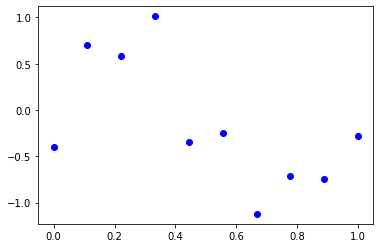

In [4]:
plt.scatter(train_set.x, train_set.y, marker='o', color='blue')

このデータに対して、最小二乗法でフィッティングした m 次多項式を決定する関数を用意します。

引数 dataset と m にトレーニングセットと多項式の次数を代入すると、多項式に対応する関数 f(x) のオブジェクトが返ります。

In [0]:
# 最小二乗法で解を求める
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0, m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi, p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return f

また、得られた関数 f(x) に対して、トレーニングセットに対する平方根平均二乗誤差（RMS）を求める関数を用意します。

In [0]:
# 平方根平均二乗誤差（Root mean square error）を計算
def rms_error(dataset, f):
    err = 0.0
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))

これらを用いて、結果をグラフに可視化する関数が次になります。

In [0]:
def show_result(subplot, train_set, m):
    f = resolve(train_set, m)
    subplot.set_xlim(-0.05, 1.05)
    subplot.set_ylim(-1.5, 1.5)
    subplot.set_title("M=%d" % m, fontsize=10)

    # トレーニングセットを表示
    subplot.scatter(train_set.x, train_set.y, marker='o',
                    color='blue', label=None)

    # 真の曲線を表示
    linex = np.linspace(0, 1, 101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 多項式近似の曲線を表示
    linex = np.linspace(0, 1, 101)
    liney = f(linex)
    label = "E(RMS)=%.2f" % rms_error(train_set, f)
    subplot.plot(linex, liney, color='red', label=label)
    subplot.legend(loc=1, fontsize=10)

先ほど生成したトレーニングセットを用いて、0, 1, 3, 9次多項式（定数関数）でフィッティングした結果を表示します。

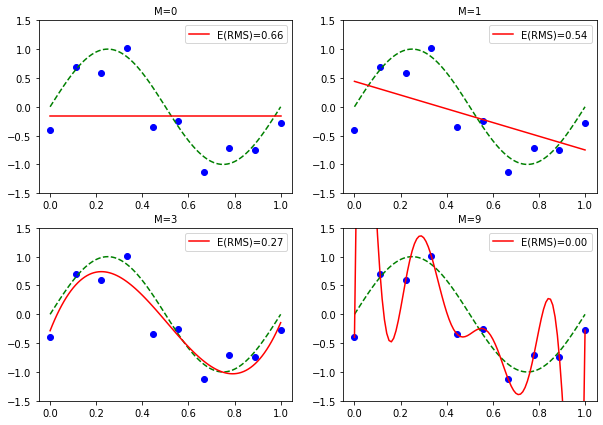

In [8]:
fig = plt.figure(figsize=(10, 7))
for i, m in enumerate([0, 1, 3, 9]):
    subplot = fig.add_subplot(2, 2, i+1)
    show_result(subplot, train_set, m)

多項式の次数が上がるにつれてデータポイントの近くを通るようになり、平方根平均二乗誤差が減少していることがわかります。

ここで、トレーニングセットとテストセットに対する平方根平均二乗誤差の変化を確認します。

多項式の次数を0〜10に変化させながら、平方根平均二乗誤差のグラフを描く関数を用意します。

In [0]:
# トレーニングセットとテストセットでの誤差の変化を表示
def show_rms_trend(train_set, test_set):
    df = DataFrame(columns=['Training set', 'Test set'])
    for m in range(0,10):   # 多項式の次数
        f = resolve(train_set, m)
        train_error = rms_error(train_set, f)
        test_error = rms_error(test_set, f)
        df = df.append(
                Series([train_error, test_error],
                        index=['Training set','Test set']),
                        ignore_index=True)
    df.plot(title='RMS Error', style=['-','--'], grid=True,
            xticks=range(0, 10), figsize=(8, 5), ylim=(0, 0.9))

トレーニングセットとは独立に生成したテストセットを用意します。

In [10]:
test_set = create_dataset(N)
test_set

,x,y
0,0.000000,0.047856
1,0.111111,0.390331
2,0.222222,1.047800
3,0.333333,0.511413
4,0.444444,-0.057306
5,0.555556,-0.282388
6,0.666667,-0.915125
7,0.777778,-1.111335
8,0.888889,-0.510968
9,1.000000,0.451367


多項式の次数を0〜10に変化させながら、トレーニングセットとテストセットに対する平方根平均二条誤差を計算して、結果をグラフ表示します。

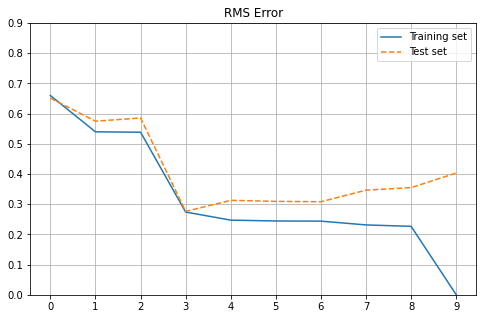

In [11]:
show_rms_trend(train_set, test_set)

次数が3を超えるとテストセットに対する誤差が減少しなくなることがわかります。

### データ数 N=100 の場合

同じ計算をデータ数を増やして実施してみます。

N=100 でトレーニングセットとテストセットを用意します。

In [0]:
N=100            # サンプルを取得する位置 x の個数
train_set = create_dataset(N)
test_set = create_dataset(N)

最小二乗法でフィッティングした結果を表示します。

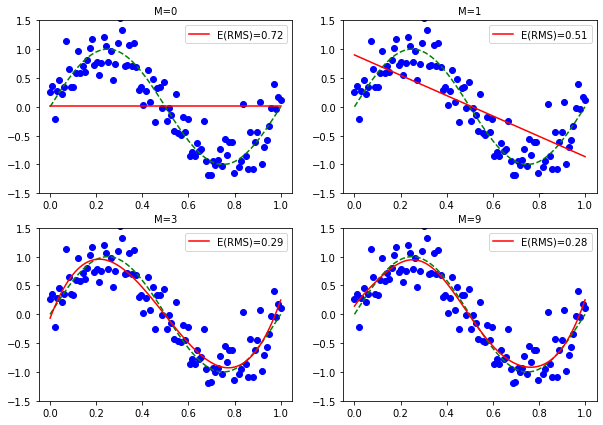

In [13]:
fig = plt.figure(figsize=(10, 7))
for i, m in enumerate([0, 1, 3, 9]):
    subplot = fig.add_subplot(2, 2, i+1)
    show_result(subplot, train_set, m)

多項式の次数があがってもオーバーフィッティングが発生しにくくなっていることがわかります。

トレーニングセットとテストセットに対する平方根平均二乗誤差の変化を表示します。

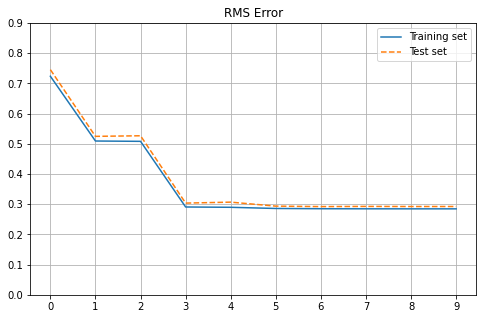

In [14]:
show_rms_trend(train_set, test_set)

次数が3を超えると平方根平均二乗誤差が約0.3で一定になります。これは、このデータが本質的に±0.3程度の誤差を持っている事を示します。